In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
ratings_df = pd.read_csv(r'C:\Users\bless\OneDrive\Desktop\WEEK1\data\raw_analyst_ratings.csv')

In [38]:
ratings_df['date'] = pd.to_datetime(ratings_df['date'], errors='coerce')

In [39]:
ratings_df = ratings_df.dropna(subset=['date'])

In [40]:
ratings_df['headline_length'] = ratings_df['headline'].astype(str).str.len()
print("Headline Length Statistics:\n", ratings_df['headline_length'].describe())

Headline Length Statistics:
 count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64


In [41]:
publisher_counts = ratings_df['publisher'].value_counts()
print("\nTop 10 Publishers:\n", publisher_counts.head(10))


Top 10 Publishers:
 publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


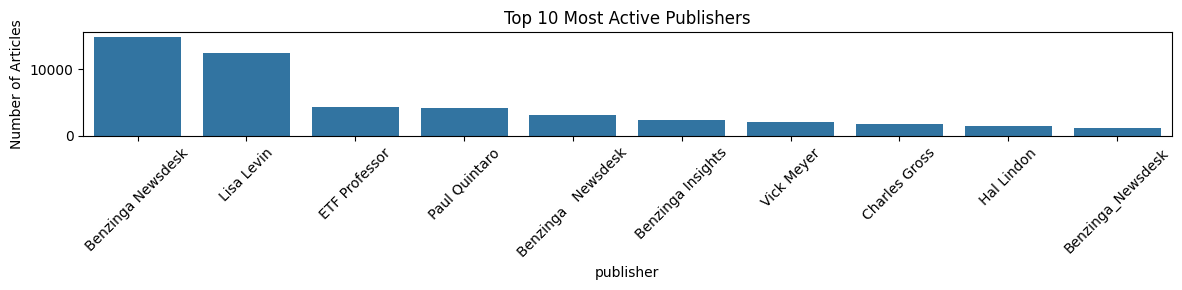

In [58]:
plt.figure(figsize=(12, 3))
sns.barplot(x=publisher_counts.index[:10], y=publisher_counts.values[:10])
plt.title("Top 10 Most Active Publishers")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d+', '', text)     
    return text

In [44]:
ratings_df['clean_headline'] = ratings_df['headline'].apply(clean_text)

In [60]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = tfidf.fit_transform(ratings_df['clean_headline'])
feature_names = tfidf.get_feature_names_out()
top_keywords = sorted(zip(tfidf.idf_, feature_names))[:30]
print("\nTop Keywords:\n", top_keywords)


Top Keywords:
 [(np.float64(2.4763174065267464), 'stocks'), (np.float64(2.832925346545724), 'week'), (np.float64(2.9251581891610154), 'shares'), (np.float64(3.1473531334792604), 'trading'), (np.float64(3.2503545370374614), 'hit'), (np.float64(3.327871759258779), 'eps'), (np.float64(3.40931986266026), 'price'), (np.float64(3.4835501365324735), 'target'), (np.float64(3.487625209195888), 'companies'), (np.float64(3.557263033946086), 'sales'), (np.float64(3.5850653152580376), 'higher'), (np.float64(3.639093052193718), 'market'), (np.float64(3.7055171542065013), 'lows'), (np.float64(3.807261672563472), 'session'), (np.float64(3.841877619330005), 'maintains'), (np.float64(3.897289968121955), 'new'), (np.float64(3.909995791439079), 'yesterday'), (np.float64(3.922865132558803), 'reports'), (np.float64(3.9715224593210254), 'moving'), (np.float64(4.0139001728752906), 'etfs'), (np.float64(4.066553737993993), 'highs'), (np.float64(4.070010626399046), 'amid'), (np.float64(4.110447931551218), 'lowe

In [46]:
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(ratings_df['clean_headline'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

for index, topic in enumerate(lda.components_):
    print(f"\nTopic #{index + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic #1:
['economic', 'following', 'amid', 'higher', 'moving', 'session', 'stocks', 'companies', 'shares', 'trading']

Topic #2:
['share', 'announces', 'etf', 'buy', 'lowers', 'raises', 'etfs', 'maintains', 'target', 'price']

Topic #3:
['thursday', 'vs', 'highs', 'sales', 'eps', 'lows', 'estimate', 'hit', 'week', 'stocks']

Topic #4:
['reports', 'energy', 'company', 'says', 'higher', 'oil', 'market', 'update', 'trading', 'shares']

Topic #5:
['eps', 'low', 'movers', 'set', 'week', 'stocks', 'biggest', 'yoy', 'yesterday', 'new']


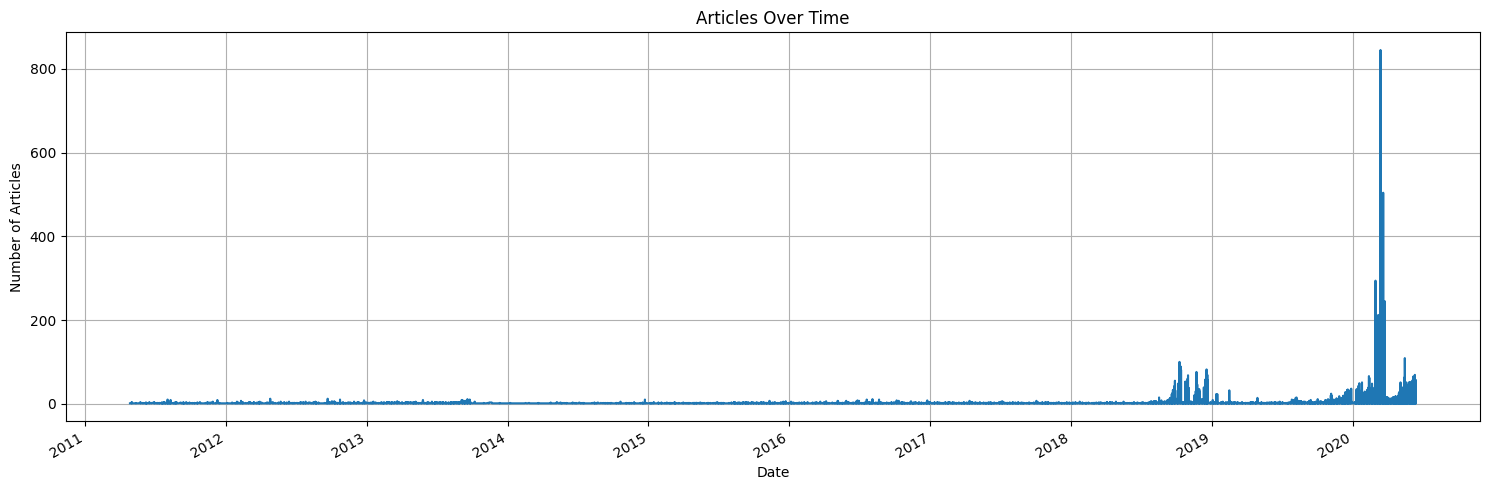

In [47]:
date_counts = ratings_df['date'].value_counts().sort_index()
date_counts.plot(kind='line', figsize=(15, 5), title="Articles Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
ratings_df['day_of_week'] = ratings_df['date'].dt.day_name()
print("\nArticles by Day of Week:\n", ratings_df['day_of_week'].value_counts())


Articles by Day of Week:
 day_of_week
Thursday     12688
Wednesday    11891
Tuesday      11002
Monday       10322
Friday        9381
Sunday         436
Saturday       267
Name: count, dtype: int64


In [49]:
daily_counts = ratings_df.groupby('date').size()

In [50]:
rolling_mean = daily_counts.rolling(window=7).mean()
spikes = daily_counts[daily_counts > 2 * rolling_mean]
print("\nSpike Dates and Counts:\n", spikes.head())


Spike Dates and Counts:
 date
2011-05-02 03:24:46-04:00    3
2011-05-02 17:12:39-04:00    4
2011-05-25 00:36:09-04:00    4
2011-06-08 04:45:23-04:00    3
2011-06-17 02:50:57-04:00    4
dtype: int64


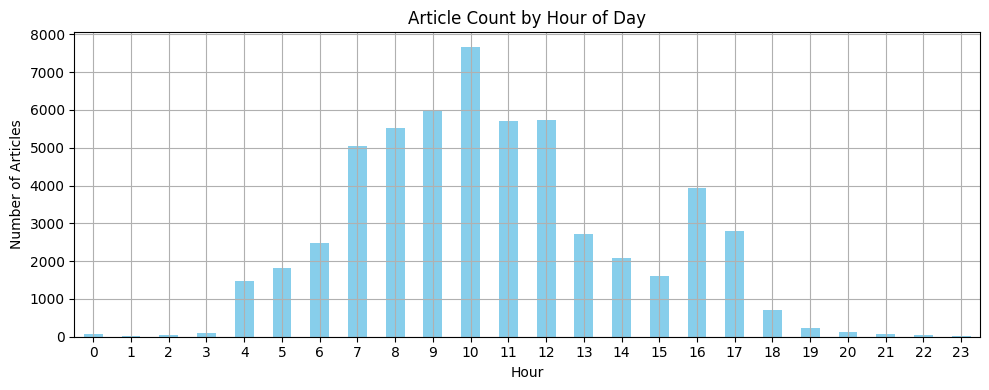

In [51]:
ratings_df['hour'] = ratings_df['date'].dt.hour
hourly_counts = ratings_df['hour'].value_counts().sort_index()
hourly_counts.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title("Article Count by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
top_publishers = ratings_df['publisher'].value_counts().head(10)
print("\nTop Publishers:\n", top_publishers)


Top Publishers:
 publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


In [53]:
ratings_df['domain'] = ratings_df['publisher'].str.extract(r'@([\w\.-]+)')
domain_counts = ratings_df['domain'].value_counts().head(10)
print("\nTop Domains:\n", domain_counts)


Top Domains:
 domain
benzinga.com    1196
gmail.com          3
Name: count, dtype: int64


In [54]:
def get_keywords(text_series):
    all_words = ' '.join(text_series.dropna()).lower().split()
    words = [w for w in all_words if w.isalpha() and w not in stop_words]
    return Counter(words).most_common(15)

In [55]:
for publisher in ratings_df['publisher'].value_counts().head(5).index:
    print(f"\nTop keywords for {publisher}:")
    headlines = ratings_df[ratings_df['publisher'] == publisher]['headline']
    print(get_keywords(headlines))


Top keywords for Benzinga Newsdesk:
[('eps', 3843), ('sales', 3374), ('stocks', 3079), ('shares', 3021), ('trading', 2875), ('new', 2389), ('set', 2104), ('estimate', 2051), ('low', 1761), ('yoy', 1338), ('companies', 1328), ('higher', 1319), ('several', 1316), ('beats', 966), ('reports', 959)]

Top keywords for Lisa Levin:
[('stocks', 6963), ('hit', 4694), ('lows', 3208), ('biggest', 2319), ('thursday', 2038), ('movers', 2027), ('moving', 1842), ('session', 1842), ('highs', 1774), ('friday', 1516), ('yesterday', 1457), ('market', 1413), ('shares', 833), ('earnings', 825), ('wednesday', 780)]

Top keywords for ETF Professor:
[('etfs', 2277), ('etf', 1507), ('watch', 347), ('new', 255), ('bond', 241), ('dividend', 207), ('could', 178), ('september', 160), ('emerging', 149), ('markets', 127), ('leveraged', 123), ('broker', 113), ('forgot', 111), ('mention', 108), ('mandatory', 104)]

Top keywords for Paul Quintaro:
[('reports', 1252), ('vs', 908), ('eps', 879), ('shares', 625), ('sales'

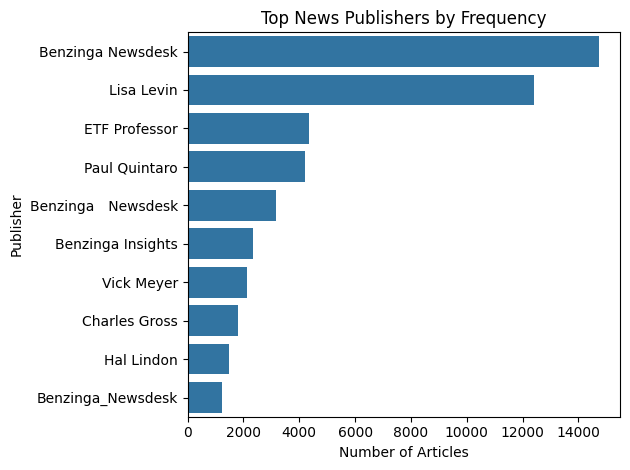

In [56]:
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title("Top News Publishers by Frequency")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.tight_layout()
plt.show()

In [57]:
ratings_df.to_csv(r"C:\Users\bless\OneDrive\Desktop\WEEK1\data\cleaned_data_set\cleaned_analyst_ratings.csv", index=False)
